# Big data project
## Project organization
We organized our project in the following way:
1. Choose a region thanks to global indicators in France
2. Choose a department in this region to refine your search
3. Choose a city to see all available house rentals

# Global indicators on regions in France
- Number of inhabitants in each region
- Population trends
- A selection of the most populated cities
- Average rental price per region
- Average rental price per region per area

In [1]:
# Usefull imports
import pandas as pd
import xml.etree.cElementTree as et
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, interact

%matplotlib inline

In [236]:
# All functions used
def select_region(Région):
    selected_region.value = str(Région)

def select_department(Département):
    selected_department.value = str(Département)

# Replace accents
def without_accents(col):
    col = col.str.replace("á", "a")
    col = col.str.replace("à", "a")
    col = col.str.replace("â", "a")
    col = col.str.replace("ä", "a")
    col = col.str.replace("ã", "a")
    col = col.str.replace("å", "a")
    col = col.str.replace("ç", "c")
    col = col.str.replace("é", "e")
    col = col.str.replace("è", "e")
    col = col.str.replace("ê", "e")
    col = col.str.replace("ë", "e")
    col = col.str.replace("í", "i")
    col = col.str.replace("ì", "i")
    col = col.str.replace("î", "i")
    col = col.str.replace("ï", "i")
    col = col.str.replace("ñ", "n")
    col = col.str.replace("ó", "o")
    col = col.str.replace("ò", "o")
    col = col.str.replace("ô", "o")
    col = col.str.replace("ö", "o")
    col = col.str.replace("õ", "o")
    col = col.str.replace("ú", "u")
    col = col.str.replace("ù", "u")
    col = col.str.replace("û", "u")
    col = col.str.replace("ü", "u")
    col = col.str.replace("ý", "y")
    col = col.str.replace("ÿ", "y")
    col = col.str.replace("æ", "ae")
    col = col.str.replace("œ", "oe")
    return col

# Return the value of a node during the reading of XML
def getValue(node):
    return node.text if node is not None else None

In [177]:
# Read CSV
electricity = pd.read_csv('consommation-electrique-par-secteur-dactivite-commune.csv', sep=";", encoding='utf-8')
# Drop useless columns
electricity.drop(["Nom EPCI", "Code EPCI", "Type EPCI", "Geo Shape", "Geo Point 2D"], axis=1, inplace=True)

# City standardization ("-" -> " " / uppercase -> lowercase / replace accents) to compare with rentals
electricity['NC'] = electricity['Nom commune']
electricity['NC'] = electricity['NC'].apply(lambda x: x.lower())
electricity['NC'] = without_accents(electricity['NC'])
electricity['NC'] = electricity['NC'].str.replace("-", " ")

electricity['ND'] = electricity['Nom département']
electricity['ND'] = electricity['ND'].apply(lambda x: x.lower())
electricity['ND'] = without_accents(electricity['ND'])
electricity['ND'] = electricity['ND'].str.replace("-", " ")

# Array of regions
regions = electricity['Nom région'].unique()
regions = sorted(regions)

# Array of departments
departments = electricity['Nom département'].unique()
departments = sorted(departments)

In [178]:
# Read XML
xml = et.parse('data.xml')

# Create a dataframe
rentals = pd.DataFrame(columns=['title', 'Prix'])

# Read data from XML file
for node in xml.getroot():
    title = node.find('title')
    price = node.find('creator')
    if title is not None and price is not None:
        rentals = rentals.append(pd.Series([getValue(title), getValue(price)], index=['title', 'Prix']), ignore_index=True)

# Split title into columns
rentals['title'] = rentals['title'].str.replace("Noorea > France > ", "")
rentals['Nom département'] = rentals['title'].str.split('>').str[1]
rentals['Nom commune'] = rentals['title'].str.split('>').str[2]
rentals['Surface'] = rentals['title'].str.split('>').str[4]
rentals['Surface'] = rentals['Surface'].str.replace(" m2", "")
rentals['Surface'] = rentals['Surface'].str.replace(" ", "")
rentals['title'] = rentals['title'].str.replace("Noorea > France > ", "")
rentals = rentals.drop('title', 1)
rentals['Prix'] = rentals['Prix'].str.replace(" €", "")
rentals['Prix'] = rentals['Prix'].str.replace(" ", "")

# Remove useless whitespaces
for index, row in rentals.iterrows():
    rentals.loc[index, 'Nom département'] = rentals.loc[index, 'Nom département'][:-1]
    rentals.loc[index, 'Nom département'] = rentals.loc[index, 'Nom département'][1:]
    rentals.loc[index, 'Nom commune'] = rentals.loc[index, 'Nom commune'][:-1]
    rentals.loc[index, 'Nom commune'] = rentals.loc[index, 'Nom commune'][1:]

# City standardization ("-" -> " " / uppercase -> lowercase / replace accents)
rentals['NC'] = rentals['Nom commune']
rentals['NC'] = rentals['NC'].apply(lambda x: x.lower())
rentals['NC'] = without_accents(rentals['NC'])
rentals['NC'] = rentals['NC'].str.replace("-", " ")

rentals['ND'] = rentals['Nom département']
rentals['ND'] = rentals['ND'].apply(lambda x: x.lower())
rentals['ND'] = without_accents(rentals['ND'])
rentals['ND'] = rentals['ND'].str.replace("-", " ")

rentals = rentals.sort_values(by=['NC', 'ND'])
electricity = electricity.sort_values(by=['NC', 'ND'])

# Electricity without years
tmp = electricity.drop_duplicates(['Nom commune', 'Nom département', 'Nom région'])
localities = tmp[['Nom commune', 'Nom département', 'Nom région', 'Nombre d\'habitants', 'NC', 'ND']]

# Association of the region with the department
for index, row in rentals.iterrows():
    tmp = localities.loc[localities['ND'] == rentals.loc[index, 'ND']]
    if not tmp.empty:
        rentals.loc[index, 'Nom région'] = tmp['Nom région'].iloc[0]

# Columns order
rentals = rentals[['Nom commune', 'Nom département', 'Nom région', 'Surface', 'Prix', 'NC', 'ND']]
rentals['Prix'] = pd.to_numeric(rentals['Prix'])
rentals['Surface'] = pd.to_numeric(rentals['Surface'])

# Merge consumption and rentals
merging = pd.merge(rentals, electricity, on=['NC', 'ND', 'Nom région'], how='inner')
merging = merging.drop(['Nom commune_x'], axis=1)
merging = merging.drop(['Nom département_x'], axis=1)
merging = merging.drop(['NC'], axis=1)
merging = merging.drop(['ND'], axis=1)
merging = merging.rename(columns={'Nom commune_y': 'Nom commune'})
merging = merging.rename(columns={'Nom département_y': 'Nom département'})
merging = merging.sort_values(by=['Nom commune', 'Nom département', 'Nom région', 'Année', 'Prix', 'Surface'])
merging = merging[['Nom commune', 'Année', 'Surface', 'Prix', 'Code commune', 'Nom département', 'Code département', 'Nom région', 'Code région', 'Nb sites Résidentiel', 'Conso totale Résidentiel (MWh)', 'Conso moyenne Résidentiel (MWh)', 'Nb sites Professionnel', 'Conso totale Professionnel (MWh)', 'Conso moyenne Professionnel (MWh)', 'Nb sites Agriculture', 'Conso totale Agriculture (MWh)', 'Nb sites Industrie', 'Conso totale Industrie (MWh)', 'Nb sites Tertiaire', 'Conso totale Tertiaire (MWh)', 'Nb sites Secteur non affecté', 'Conso totale Secteur non affecté (MWh)', "Nombre d'habitants", 'Taux de logements collectifs', 'Taux de résidences principales', 'Superficie des logements < 30 m2', 'Superficie des logements 30 à 40 m2', 'Superficie des logements 40 à 60 m2', 'Superficie des logements 60 à 80 m2', 'Superficie des logements 80 à 100 m2', 'Superficie des logements > 100 m2', 'Résidences principales avant 1919', 'Résidences principales de 1919 à 1945', 'Résidences principales de 1946 à 1970', 'Résidences principales de 1971 à 1990', 'Résidences principales de 1991 à 2005', 'Résidences principales de 2006 à 2010', 'Résidences principales après 2011', 'Taux de chauffage électrique']]

## Global statistics
### Number of inhabitants in each region

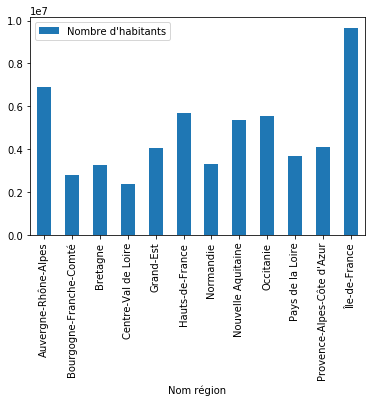

In [170]:
# Total population
total_population = localities['Nombre d\'habitants'].sum(axis=0)

# Population per regions
population_by_region = pd.DataFrame(columns=['Nom région', 'Nombre d\'habitants'])
population_by_region['Nom région'] = regions

for index, row in population_by_region.iterrows():
    population_by_region.loc[index, 'Nombre d\'habitants'] = localities.loc[localities['Nom région'] == population_by_region.loc[index, 'Nom région'], 'Nombre d\'habitants'].sum(axis=0)
population_by_region = population_by_region.set_index('Nom région')

#ax1 = plt.subplot(121, aspect='equal')
#population_by_region.plot(kind='pie', y='Nombre d\'habitants', ax=ax1, figsize=(15,15), labels=population_by_region.index, legend=False, fontsize=8, autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.2)
population_by_region.plot(kind='bar')

### Population trends

Figures aren't very accurate, that's why curves are linear


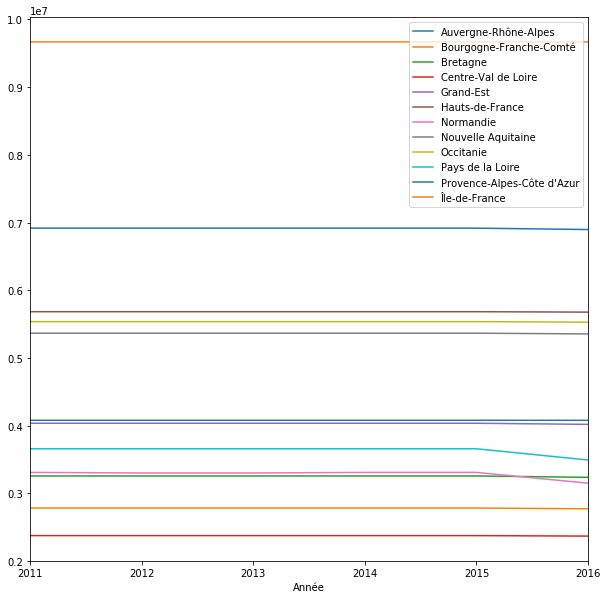

In [199]:
# Evolution of population
trends_population_by_region = pd.DataFrame(columns=[regions])
trends_population_by_region['Année'] = []
trends_population_by_region['Année'] = trends_population_by_region['Année'].astype(int)
trends_population_by_region = trends_population_by_region.set_index('Année')

for index, row in trends_population_by_region.iteritems():
    trends_population_by_region.loc[2011, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2011), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2012, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2012), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2013, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2013), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2014, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2014), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2015, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2015), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_region.loc[2016, index] = electricity.loc[(electricity['Nom région'] == index) & (electricity['Année'] == 2016), 'Nombre d\'habitants'].sum(axis=0)
print("Figures aren't very accurate, that's why curves are linear")
trends_population_by_region.plot(figsize=(10,10)) 

### A selection of the most populated cities

In [206]:
major_cities_regions = pd.DataFrame(columns=['Nom région', 'Nom commune', 'Nombre d\'habitants'])
major_cities_regions['Nom région'] = regions
for index, row in major_cities_regions.iterrows():
    major_cities_regions.loc[index, 'Nombre d\'habitants'] = localities.loc[(localities['Nom région'] == major_cities_regions.loc[index, 'Nom région']), 'Nombre d\'habitants'].max(axis=0)
    major_cities_regions.loc[index, 'Nom commune'] = (localities['Nom commune'][localities['Nombre d\'habitants'] == major_cities_regions.loc[index, 'Nombre d\'habitants']]).iloc[0]
print("Fluctuations may occur due to the data quality of the source file")
major_cities_regions

Fluctuations may occur due to the data quality of the source file


,Nom région,Nom commune,Nombre d'habitants
0,Auvergne-Rhône-Alpes,Saint-Étienne,172022
1,Bourgogne-Franche-Comté,Dijon,153003
2,Bretagne,Rennes,211372
3,Centre-Val de Loire,Tours,134802
4,Grand-Est,Reims,182592
5,Hauts-de-France,Lille,231490
6,Normandie,Le Havre,172073
7,Nouvelle Aquitaine,Bordeaux,243625
8,Occitanie,Toulouse,458298
9,Pays de la Loire,Nantes,292717


### Average rental price per region

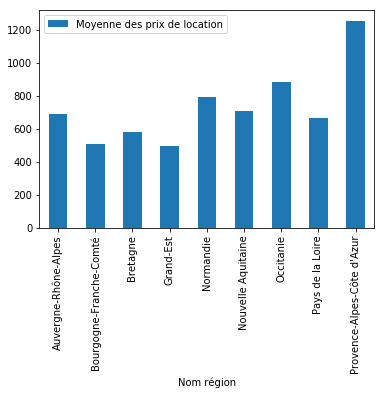

In [211]:
rental_prices = pd.DataFrame(columns=['Nom commune', 'Nom département', 'Nom région', 'Moyenne des prix de location', 'Prix < 30 m2', 'Prix 30-40 m2', 'Prix 40-60 m2', 'Prix 60-80 m2', 'Prix 80-100 m2', 'Prix > 100 m2'])
rental_prices['Nom commune'] = rentals['Nom commune']
rental_prices['Nom département'] = rentals['Nom département']
rental_prices['Nom région'] = rentals['Nom région']
rental_prices['Moyenne des prix de location'] = rentals['Prix']

for index, row in rentals.iterrows():
    if rentals.loc[index, 'Surface'] < 30:
        rental_prices.loc[(rental_prices['Nom région'] == rentals.loc[index, 'Nom région']) & (rental_prices['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix < 30 m2'] = rentals.loc[index, 'Prix']
    elif (rentals.loc[index, 'Surface'] >= 30) & (rentals.loc[index, 'Surface'] < 40):
        rental_prices.loc[(rental_prices['Nom région'] == rentals.loc[index, 'Nom région']) & (rental_prices['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix 30-40 m2'] = rentals.loc[index, 'Prix']
    elif (rentals.loc[index, 'Surface'] >= 40) & (rentals.loc[index, 'Surface'] < 60):
        rental_prices.loc[(rental_prices['Nom région'] == rentals.loc[index, 'Nom région']) & (rental_prices['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix 40-60 m2'] = rentals.loc[index, 'Prix']
    elif (rentals.loc[index, 'Surface'] >= 60) & (rentals.loc[index, 'Surface'] < 80):
        rental_prices.loc[(rental_prices['Nom région'] == rentals.loc[index, 'Nom région']) & (rental_prices['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix 60-80 m2'] = rentals.loc[index, 'Prix']
    elif (rentals.loc[index, 'Surface'] >= 80) & (rentals.loc[index, 'Surface'] < 100):
        rental_prices.loc[(rental_prices['Nom région'] == rentals.loc[index, 'Nom région']) & (rental_prices['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix 80-100 m2'] = rentals.loc[index, 'Prix']
    elif rentals.loc[index, 'Surface'] >= 100:
        rental_prices.loc[(rental_prices['Nom région'] == rentals.loc[index, 'Nom région']) & (rental_prices['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix > 100 m2'] = rentals.loc[index, 'Prix']
rental_prices = rental_prices.dropna(subset=['Moyenne des prix de location'])

average_rental_prices_regions = pd.DataFrame(columns=['Nom région', 'Moyenne des prix de location', 'Prix < 30 m2', 'Prix 30-40 m2', 'Prix 40-60 m2', 'Prix 60-80 m2', 'Prix 80-100 m2', 'Prix > 100 m2'])
average_rental_prices_regions['Nom région'] = regions
for index, row in average_rental_prices_regions.iterrows():
    average_rental_prices_regions.loc[index, 'Moyenne des prix de location'] = rental_prices.loc[rental_prices['Nom région'] == average_rental_prices_regions.loc[index, 'Nom région'], 'Moyenne des prix de location'].mean()
    average_rental_prices_regions.loc[index, 'Prix < 30 m2'] = rental_prices.loc[rental_prices['Nom région'] == average_rental_prices_regions.loc[index, 'Nom région'], 'Prix < 30 m2'].mean()
    average_rental_prices_regions.loc[index, 'Prix 30-40 m2'] = rental_prices.loc[rental_prices['Nom région'] == average_rental_prices_regions.loc[index, 'Nom région'], 'Prix 30-40 m2'].mean()
    average_rental_prices_regions.loc[index, 'Prix 40-60 m2'] = rental_prices.loc[rental_prices['Nom région'] == average_rental_prices_regions.loc[index, 'Nom région'], 'Prix 40-60 m2'].mean()
    average_rental_prices_regions.loc[index, 'Prix 60-80 m2'] = rental_prices.loc[rental_prices['Nom région'] == average_rental_prices_regions.loc[index, 'Nom région'], 'Prix 60-80 m2'].mean()
    average_rental_prices_regions.loc[index, 'Prix 80-100 m2'] = rental_prices.loc[rental_prices['Nom région'] == average_rental_prices_regions.loc[index, 'Nom région'], 'Prix 80-100 m2'].mean()
    average_rental_prices_regions.loc[index, 'Prix > 100 m2'] = rental_prices.loc[rental_prices['Nom région'] == average_rental_prices_regions.loc[index, 'Nom région'], 'Prix > 100 m2'].mean()
average_rental_prices_regions = average_rental_prices_regions.dropna(subset=['Moyenne des prix de location'])
average_rental_prices_regions = average_rental_prices_regions.set_index('Nom région')

average_rental_prices_regions.plot(kind='bar', y='Moyenne des prix de location')

### Average rental price per region per area

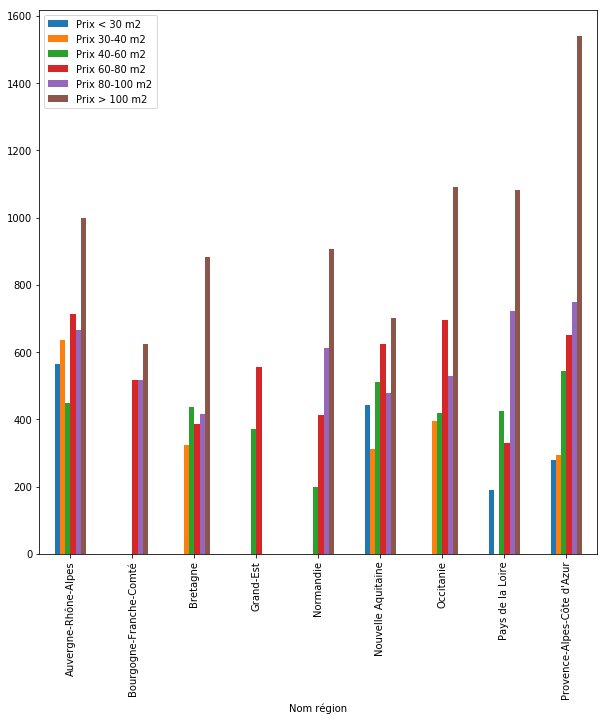

In [212]:
average_rental_prices_regions.plot(kind='bar', y=['Prix < 30 m2', 'Prix 30-40 m2', 'Prix 40-60 m2', 'Prix 60-80 m2', 'Prix 80-100 m2', 'Prix > 100 m2'], figsize=(10,10))

### Select a region to continue

In [173]:
# Create text widget for output
selected_region = widgets.Text()

interact(select_region, Région=regions)

# Display output variable in text box
selected_region

A Jupyter Widget

A Jupyter Widget

# Indicators in the selected region
- Statistics about each department:
    - Number of inhabitants
    - Population trends
    - A selection of the most populated cities
    - Average rental price per department
    - Average rental price per department per area
    - Percentage of economic activities (agriculture, tertiary, industry)

### Inhabitants

Total population of the selected region: 6,919,657


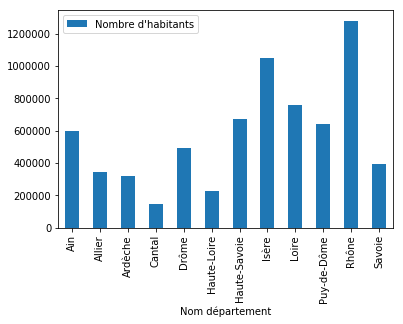

In [230]:
# Population per departments
population_by_department = pd.DataFrame(columns=['Nom département', 'Nombre d\'habitants'])
population_by_department['Nom département'] = sorted((localities["Nom département"][(localities["Nom région"] == selected_region.value)]).drop_duplicates())

for index, row in population_by_department.iterrows():
    population_by_department.loc[index, 'Nombre d\'habitants'] = localities.loc[localities['Nom département'] == population_by_department.loc[index, 'Nom département'], 'Nombre d\'habitants'].sum(axis=0)
population_by_department = population_by_department.set_index('Nom département')

#ax1 = plt.subplot(121, aspect='equal')
#population_by_department.plot(kind='pie', y='Nombre d\'habitants', ax=ax1, figsize=(15,15), labels=population_by_department.index, legend=False, fontsize=8, autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.2)
population_by_department.plot(kind='bar')
total_population_by_selected_region = population_by_department['Nombre d\'habitants'].sum()
print("Total population of the selected region: " + "{:,}".format(total_population_by_selected_region))

### Population trends

Figures aren't very accurate, that's why curves are linear


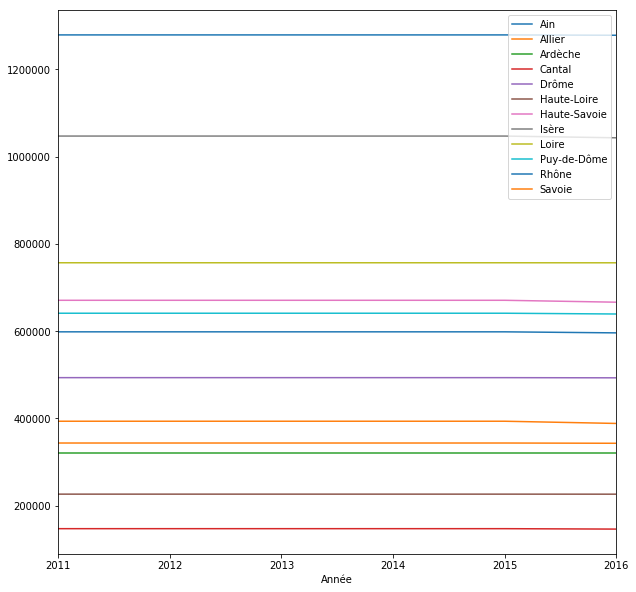

In [231]:
# Departments of the selected region
tmp = pd.DataFrame(columns=['Nom département'])
tmp['Nom département'] = electricity.loc[(electricity['Nom région'] == selected_region.value), 'Nom département']
tmp = tmp.drop_duplicates()
departments_selected_region = tmp['Nom département'].unique()
departments_selected_region = sorted(departments_selected_region)

# Evolution of population
trends_population_by_department = pd.DataFrame(columns=[departments_selected_region])
trends_population_by_department['Année'] = []
trends_population_by_department['Année'] = trends_population_by_department['Année'].astype(int)
trends_population_by_department = trends_population_by_department.set_index('Année')
trends_population_by_department

for index, row in trends_population_by_department.iteritems():
    trends_population_by_department.loc[2011, index] = electricity.loc[(electricity['Nom région'] == selected_region.value) & (electricity['Nom département'] == index) & (electricity['Année'] == 2011), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_department.loc[2012, index] = electricity.loc[(electricity['Nom région'] == selected_region.value) & (electricity['Nom département'] == index) & (electricity['Année'] == 2012), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_department.loc[2013, index] = electricity.loc[(electricity['Nom région'] == selected_region.value) & (electricity['Nom département'] == index) & (electricity['Année'] == 2013), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_department.loc[2014, index] = electricity.loc[(electricity['Nom région'] == selected_region.value) & (electricity['Nom département'] == index) & (electricity['Année'] == 2014), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_department.loc[2015, index] = electricity.loc[(electricity['Nom région'] == selected_region.value) & (electricity['Nom département'] == index) & (electricity['Année'] == 2015), 'Nombre d\'habitants'].sum(axis=0)
    trends_population_by_department.loc[2016, index] = electricity.loc[(electricity['Nom région'] == selected_region.value) & (electricity['Nom département'] == index) & (electricity['Année'] == 2016), 'Nombre d\'habitants'].sum(axis=0)
print("Figures aren't very accurate, that's why curves are linear")
trends_population_by_department.plot(figsize=(10,10))

### A selection of the most populated cities

In [232]:
major_cities_deparments = pd.DataFrame(columns=['Nom département', 'Nom commune', 'Nombre d\'habitants'])
major_cities_deparments['Nom département'] = departments_selected_region

for index, row in major_cities_deparments.iterrows():
    major_cities_deparments.loc[index, 'Nombre d\'habitants'] = localities.loc[(localities['Nom région'] == selected_region.value) & (localities['Nom département'] == major_cities_deparments.loc[index, 'Nom département']), 'Nombre d\'habitants'].max(axis=0)
    major_cities_deparments.loc[index, 'Nom commune'] = (localities['Nom commune'][(localities['Nombre d\'habitants'] == major_cities_deparments.loc[index, 'Nombre d\'habitants']) & (localities['Nom département'] == major_cities_deparments.loc[index, 'Nom département'])]).iloc[0]
print("Fluctuations may occur due to the data quality of the source file")
major_cities_deparments

Fluctuations may occur due to the data quality of the source file


,Nom département,Nom commune,Nombre d'habitants
0,Ain,Bourg-en-Bresse,40489
1,Allier,Montluçon,37839
2,Ardèche,Annonay,16074
3,Cantal,Aurillac,26572
4,Drôme,Valence,61766
5,Haute-Loire,Le Puy-en-Velay,18619
6,Haute-Savoie,Annecy,52028
7,Isère,Saint-Martin-d'Hères,38019
8,Loire,Saint-Étienne,172022
9,Puy-de-Dôme,Clermont-Ferrand,141463


### Average rental price per department

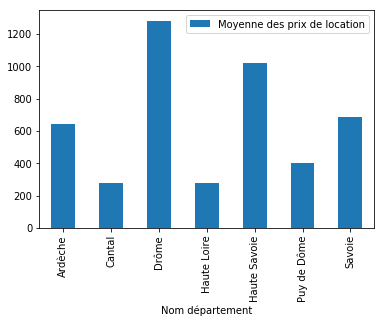

In [233]:
rental_prices_department = pd.DataFrame(columns=['Nom commune', 'Nom département', 'Moyenne des prix de location', 'Prix < 30 m2', 'Prix 30-40 m2', 'Prix 40-60 m2', 'Prix 60-80 m2', 'Prix 80-100 m2', 'Prix > 100 m2'])
rental_prices_department['Nom commune'] = rentals.loc[rentals['Nom région'] == selected_region.value, 'Nom commune']
rental_prices_department['Nom département'] = rentals.loc[rentals['Nom région'] == selected_region.value, 'Nom département']
rental_prices_department['Moyenne des prix de location'] = rentals.loc[rentals['Nom région'] == selected_region.value, 'Prix']

for index, row in rentals.iterrows():
    if rentals.loc[index, 'Surface'] < 30:
        rental_prices_department.loc[(rental_prices_department['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices_department['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix < 30 m2'] = rentals.loc[index, 'Prix']
    elif (rentals.loc[index, 'Surface'] >= 30) & (rentals.loc[index, 'Surface'] < 40):
        rental_prices_department.loc[(rental_prices_department['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices_department['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix 30-40 m2'] = rentals.loc[index, 'Prix']
    elif (rentals.loc[index, 'Surface'] >= 40) & (rentals.loc[index, 'Surface'] < 60):
        rental_prices_department.loc[(rental_prices_department['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices_department['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix 40-60 m2'] = rentals.loc[index, 'Prix']
    elif (rentals.loc[index, 'Surface'] >= 60) & (rentals.loc[index, 'Surface'] < 80):
        rental_prices_department.loc[(rental_prices_department['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices_department['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix 60-80 m2'] = rentals.loc[index, 'Prix']
    elif (rentals.loc[index, 'Surface'] >= 80) & (rentals.loc[index, 'Surface'] < 100):
        rental_prices_department.loc[(rental_prices_department['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices_department['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix 80-100 m2'] = rentals.loc[index, 'Prix']
    elif rentals.loc[index, 'Surface'] >= 100:
        rental_prices_department.loc[(rental_prices_department['Nom département'] == rentals.loc[index, 'Nom département']) & (rental_prices_department['Nom commune'] == rentals.loc[index, 'Nom commune']), 'Prix > 100 m2'] = rentals.loc[index, 'Prix']
rental_prices_department = rental_prices_department.dropna(subset=['Moyenne des prix de location'])

average_rental_prices_deparments = pd.DataFrame(columns=['Nom département', 'Moyenne des prix de location', 'Prix < 30 m2', 'Prix 30-40 m2', 'Prix 40-60 m2', 'Prix 60-80 m2', 'Prix 80-100 m2', 'Prix > 100 m2'])
average_rental_prices_deparments['Nom département'] = sorted(rental_prices_department['Nom département'].unique())
for index, row in average_rental_prices_deparments.iterrows():
    average_rental_prices_deparments.loc[index, 'Moyenne des prix de location'] = rental_prices_department.loc[rental_prices_department['Nom département'] == average_rental_prices_deparments.loc[index, 'Nom département'], 'Moyenne des prix de location'].mean()
    average_rental_prices_deparments.loc[index, 'Prix < 30 m2'] = rental_prices_department.loc[rental_prices_department['Nom département'] == average_rental_prices_deparments.loc[index, 'Nom département'], 'Prix < 30 m2'].mean()
    average_rental_prices_deparments.loc[index, 'Prix 30-40 m2'] = rental_prices_department.loc[rental_prices_department['Nom département'] == average_rental_prices_deparments.loc[index, 'Nom département'], 'Prix 30-40 m2'].mean()
    average_rental_prices_deparments.loc[index, 'Prix 40-60 m2'] = rental_prices_department.loc[rental_prices_department['Nom département'] == average_rental_prices_deparments.loc[index, 'Nom département'], 'Prix 40-60 m2'].mean()
    average_rental_prices_deparments.loc[index, 'Prix 60-80 m2'] = rental_prices_department.loc[rental_prices_department['Nom département'] == average_rental_prices_deparments.loc[index, 'Nom département'], 'Prix 60-80 m2'].mean()
    average_rental_prices_deparments.loc[index, 'Prix 80-100 m2'] = rental_prices_department.loc[rental_prices_department['Nom département'] == average_rental_prices_deparments.loc[index, 'Nom département'], 'Prix 80-100 m2'].mean()
    average_rental_prices_deparments.loc[index, 'Prix > 100 m2'] = rental_prices_department.loc[rental_prices_department['Nom département'] == average_rental_prices_deparments.loc[index, 'Nom département'], 'Prix > 100 m2'].mean()
#average_rental_prices_deparments = average_rental_prices_deparments.dropna(subset=['Moyenne des prix de location'])
average_rental_prices_deparments = average_rental_prices_deparments.set_index('Nom département')

average_rental_prices_deparments.plot(kind='bar', y='Moyenne des prix de location')

### Average rental price per department per area

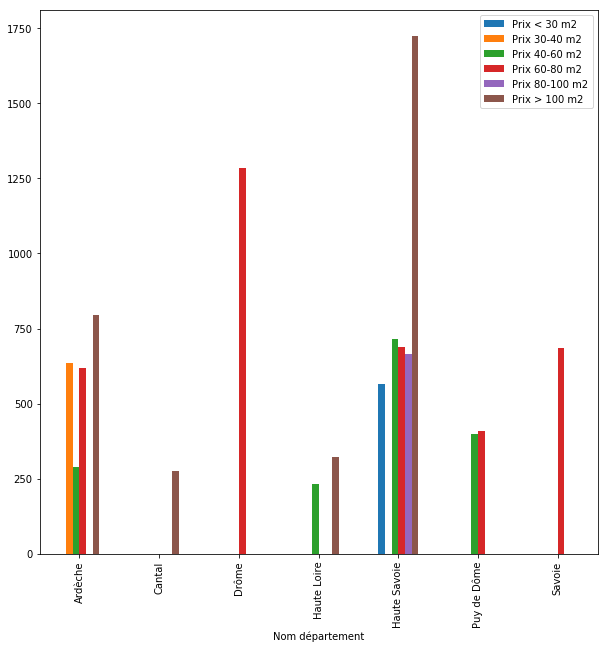

In [234]:
average_rental_prices_deparments.plot(kind='bar', y=['Prix < 30 m2', 'Prix 30-40 m2', 'Prix 40-60 m2', 'Prix 60-80 m2', 'Prix 80-100 m2', 'Prix > 100 m2'], figsize=(10,10))

### Select a department to continue

In [237]:
# Create text widget for output
selected_department = widgets.Text()

interact(select_department, Département=departments_selected_region)

# Display output variable in text box
selected_department

A Jupyter Widget

A Jupyter Widget

# Indicators  in the selected department
- Statistics about 
- City with house rentals
- ...